# MED 7 Machine leaning mini project
*Sebastian Whitehead 20204568*
*MED 7 2023*


### Table of content:
---
1. [Data dowloading and importing](#item-one)
2. [Preliminary data plotting](#item-two)
3. [Test & training set creation](#item-three)
4. [Data investigation and discovery](#item-four)
5. [Prepping data for Machine leaning](#item-five)
---

<a id="item-one"></a>
## Data downloading and importing
The following code downloads a fresh copy of the data from the provided URL and extracts this data to a sub directory of the project folder.

In [458]:
import os
import urllib.request
import zipfile
import shutil

url = "https://archive.ics.uci.edu/static/public/864/room+occupancy+estimation.zip"
folder = "data"

#If folder already exists remove
if os.path.exists(folder):
    shutil.rmtree(folder)
    
os.makedirs(folder) # create data directory

compressedFile, _ = urllib.request.urlretrieve(url) # Get the zip file from the data url

with zipfile.ZipFile(compressedFile, 'r') as zip: # Extract the zipfile to the data folder
    zip.extractall(folder)
    
 # Delete the zipfile that was downloaded
os.remove(compressedFile)

Read the now dowloaded CSV file with the padas package and describe the data using the same package

In [459]:
import pandas as pd
from pathlib import Path

# Import the CSV file
csv_file = Path("data/Occupancy_Estimation.csv")
df = pd.read_csv(csv_file)

# Print the DataFrame

df.head()
#print(df.info())
#df.describe()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


---
<a id="item-two"></a>
## Preliminary plotting of data
The following code uses matplotlib to plot the data in histogram format. This is done as a means to create a better understanding of the datas distrobution and scale, and will be used for considerations into what sort of transformations that will likly have to to the different sensor values.

In [460]:
# extra code – code to save the figures as high-res PNGs for the book

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

<function matplotlib.pyplot.show(close=None, block=None)>

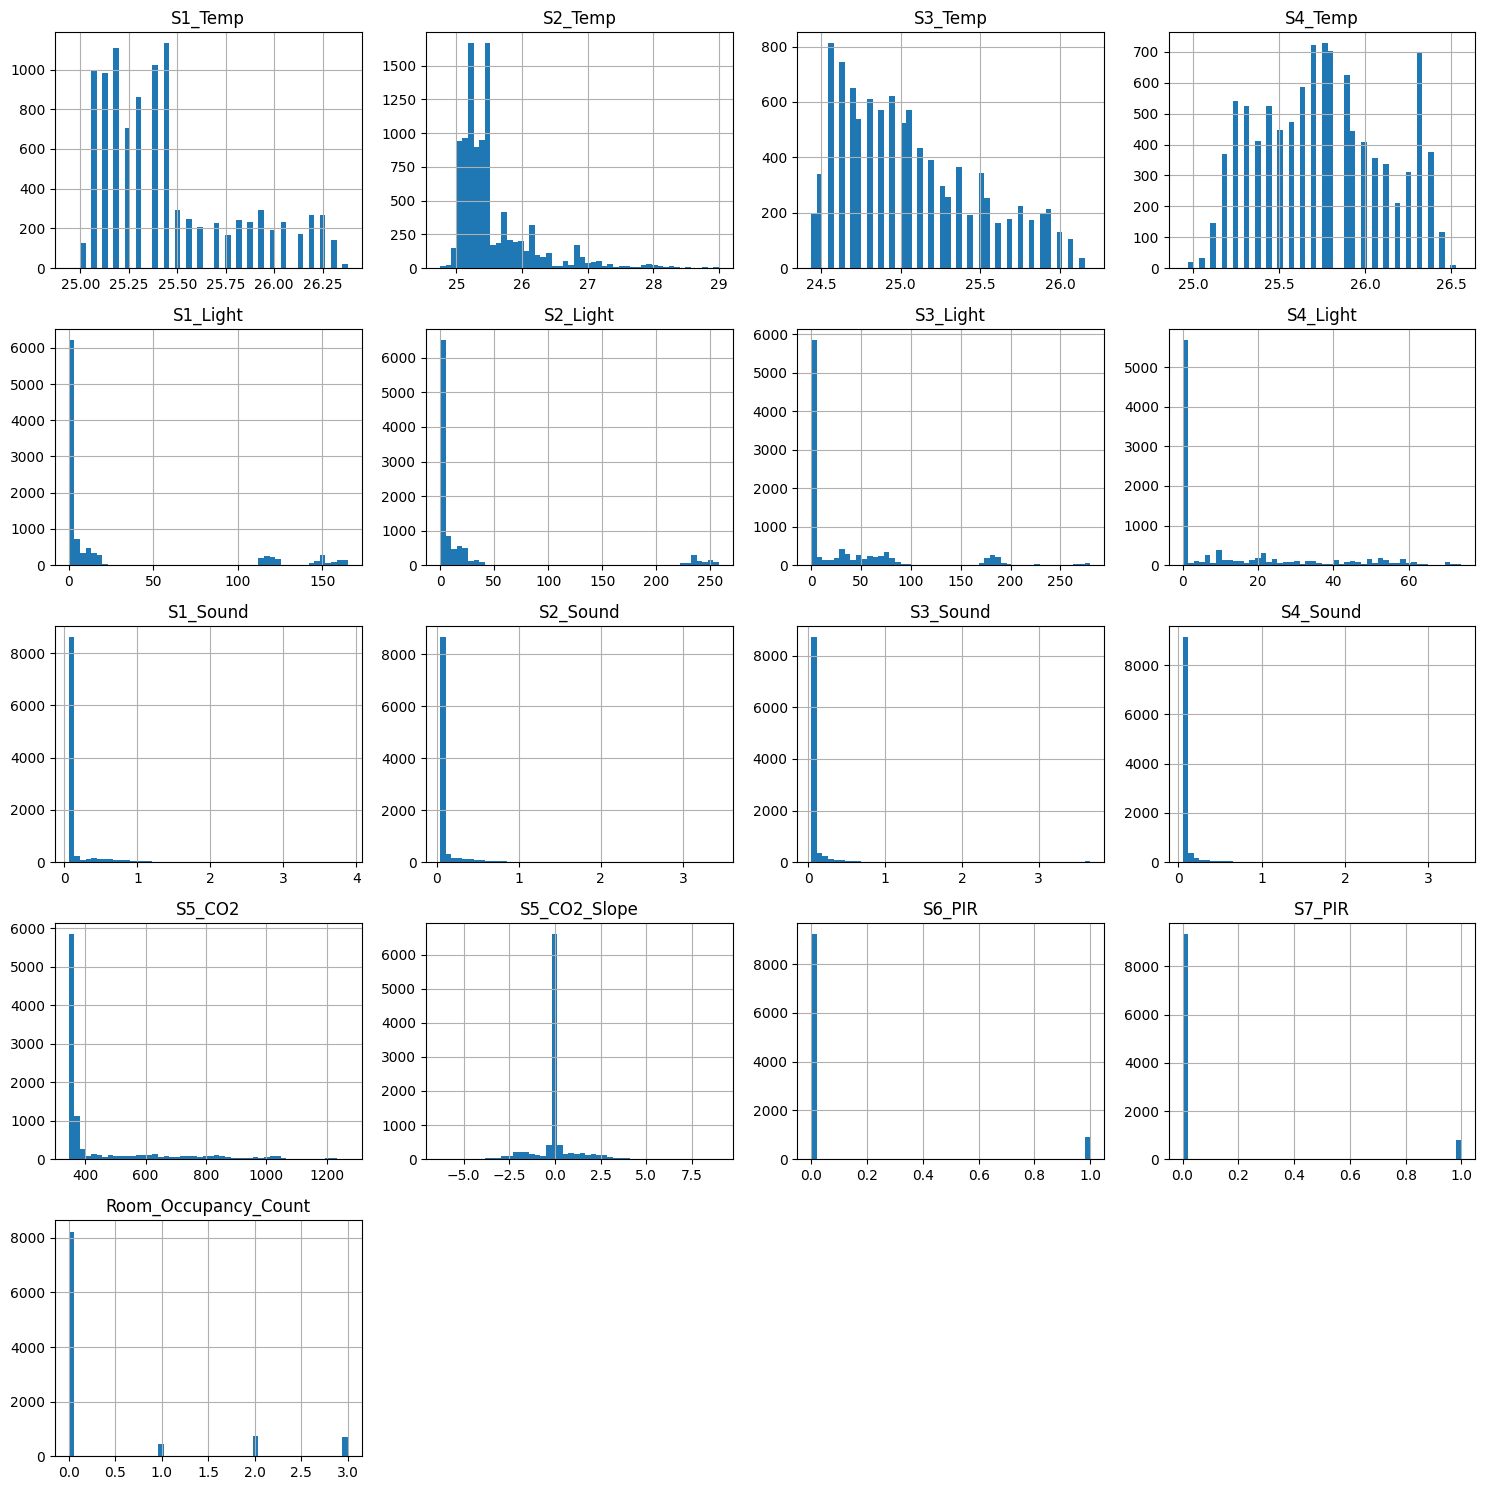

In [461]:
import matplotlib.pyplot as plt

plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=7)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(15, 15))
save_fig("attribute_hisogram_plots")
plt.show


---
<a id="item-three"></a>
## Test & Training data set creation

In [462]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

*Fixed seed value generated by random.org*

In [463]:
np.random.seed(316)
train_set, test_set = shuffle_and_split_data(df, 0.2)

In [464]:
train_set, test_set = shuffle_and_split_data(df, 0.2)

print(f'Test set length:  {len(test_set)}  , Training set length: {len(train_set)}')
print(f'Actual percentage = {len(test_set) / (len(train_set) + len(test_set)) * 100 }%')

Test set length:  2025  , Training set length: 8104
Actual percentage = 19.992101885674796%


### Alternative Method using sklearn


In [465]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=316)

print(f'Test set length:  {len(test_set)}  , Training set length: {len(train_set)}')
print(f'Actual percentage = {len(test_set) / (len(train_set) + len(test_set)) * 100 }%')

Test set length:  2026  , Training set length: 8103
Actual percentage = 20.0019745285813%


<a id="item-four"></a>
## Data discovery & dimensionalty reduction


#### Looking for correlations

In [466]:
df = train_set.copy();

Combining other data from sensors of simmilar type through adveraging each entry is completed through the code below. It is also here that experimentation with combining the binary outputs of the passive infrared sensors through logic gates specifically 'OR' and 'AND' operations.

In [467]:
# Creates 3 New colums which average All 3 Temp, Light and sound sensors
df['average_Temp'] = df[['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp' ]].mean(axis=1)
df['average_Light'] = df[['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']].mean(axis=1)
df['average_Sound'] = df[['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']].mean(axis=1)
df['OR_PIR'] = df[['S6_PIR', 'S7_PIR']].max(axis=1)
df['AND_PIR'] = df[['S6_PIR', 'S7_PIR']].min(axis=1)

While it is doubtfull that the date varriables may produce any significant correlation especially since the data was recorded only over a couple of days so while there logically may be differences in room occupancy based on day of the week there is likly not enough data to support that conclusion

In [468]:
df['Date'] = pd.to_datetime(df['Date'])         # Format the date string to a valid date value with pandas
df['Day_of_week'] = df['Date'].dt.day_name()    # Add a string value for the given day of the week
df['Day_of_week_int'] = df['Date'].dt.dayofweek # Create a column representing the day of the week with Monday as 0 and Sunday as 7

With these new combined varriables created it is now relevant to check the each varriables correlation against the target value of *Room_Occupancy_Count*. Firstly this is done with the following code that gernated a correlation matrix displaying values which the closer they are too **1** (values is from -1 to 1) the higher better the correlation.

In [469]:
# Creates a corrilation matrix currently ignoring currently unprocessable columns
selected_columns = [col for col in df.columns if col not in ['Day_of_week', 'Time']]
corr_matrix = df[selected_columns].corr()
corr_matrix["Room_Occupancy_Count"].sort_values(ascending=False)

Room_Occupancy_Count    1.000000
average_Light           0.855256
S1_Light                0.850067
S3_Light                0.792481
S2_Light                0.791474
OR_PIR                  0.772905
S1_Temp                 0.699941
S7_PIR                  0.699895
average_Temp            0.693742
S2_Temp                 0.672395
average_Sound           0.662375
S5_CO2                  0.660629
S3_Temp                 0.651267
S6_PIR                  0.635174
S5_CO2_Slope            0.606538
S1_Sound                0.585116
S2_Sound                0.564139
AND_PIR                 0.551362
S3_Sound                0.538230
S4_Temp                 0.526601
S4_Sound                0.476506
S4_Light                0.356982
Day_of_week_int         0.167414
Date                   -0.077330
Name: Room_Occupancy_Count, dtype: float64

From the above correlation matrix it is easily concluded that the majority of sensors have a considerable correlation agains the target value. While this is true having more values of simmilar type could create biases towards said values. So the highest correlation value for each sensor type will be included going forward, these are the following:
- S1_Temp
- average_Light
- average_sound
- S5_CO2
- S5_CO2_Slope
- OR_PIR

it is of note that while S1 temp sensor has a higher correlation in the training set and while this may not be true for the whole data set or a theoretical expanded dataset it true for the partitioned training set.


The bellow code selects these varriables and graphs each in a scatterplot against room_occupancy_count

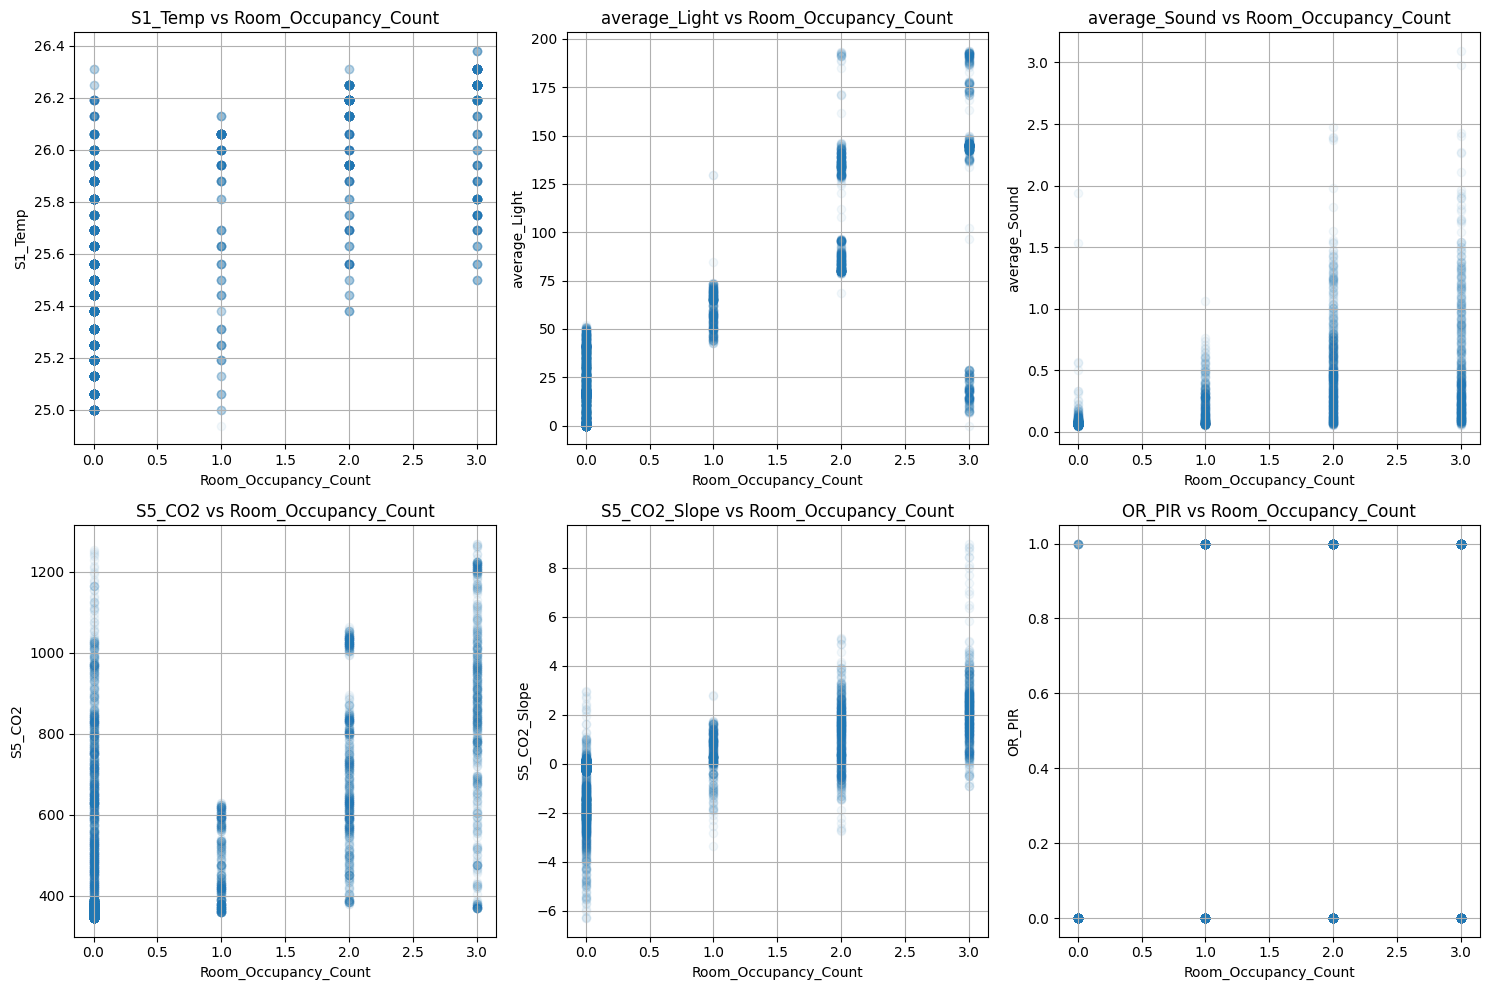

In [470]:
import os

# Assuming 'df' is your DataFrame containing the data

attributes = ["S1_Temp", "average_Light", "average_Sound", "S5_CO2", "S5_CO2_Slope", "OR_PIR"]

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))  # 2 rows, 3 columns

# Create the "images" subfolder for saving plots
os.makedirs("images", exist_ok=True)

for i, attribute in enumerate(attributes):
    row, col = divmod(i, 3)  # Divide the attributes into rows and columns
    axes[row, col].scatter(df["Room_Occupancy_Count"], df[attribute], alpha = 0.05)
    axes[row, col].set_title(f"{attribute} vs Room_Occupancy_Count")
    axes[row, col].set_xlabel("Room_Occupancy_Count")
    axes[row, col].set_ylabel(attribute)
    axes[row, col].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the combined plot in the "images" subfolder
output_path = os.path.join("images", "combined_scatter_plots.png")
plt.savefig(output_path)
plt.show()


The above plots even before any transformations appear to suggest linear or near linear correlation for all but the room_occupancy_count but that will be easily tested later when applying models to the tranformed data

---
<a id="item-five"></a>
## Prepping data for Machine leaning

Fist and foremost through reading both the introductory report together with the data set description it is said that the data has no siginificant outliers or missing values  so no measures need to be taken to that extent. (it is of note that from the above scatter plots there is potential outliers in average_light but their effect may be insignificant so exclusion may not be nessasary)

Firstly i will stat by creating a dataframe called occupancy only containing the selected varriables and a data_frame containing the room_occupancy_count varriable

In [471]:
df_selection = df[["S1_Temp", "average_Light", "average_Sound", "S5_CO2", "S5_CO2_Slope", "OR_PIR", "Room_Occupancy_Count"]].copy()
occupancy = df_selection.drop("Room_Occupancy_Count", axis=1)
occupancy_labels = train_set["Room_Occupancy_Count"].copy()

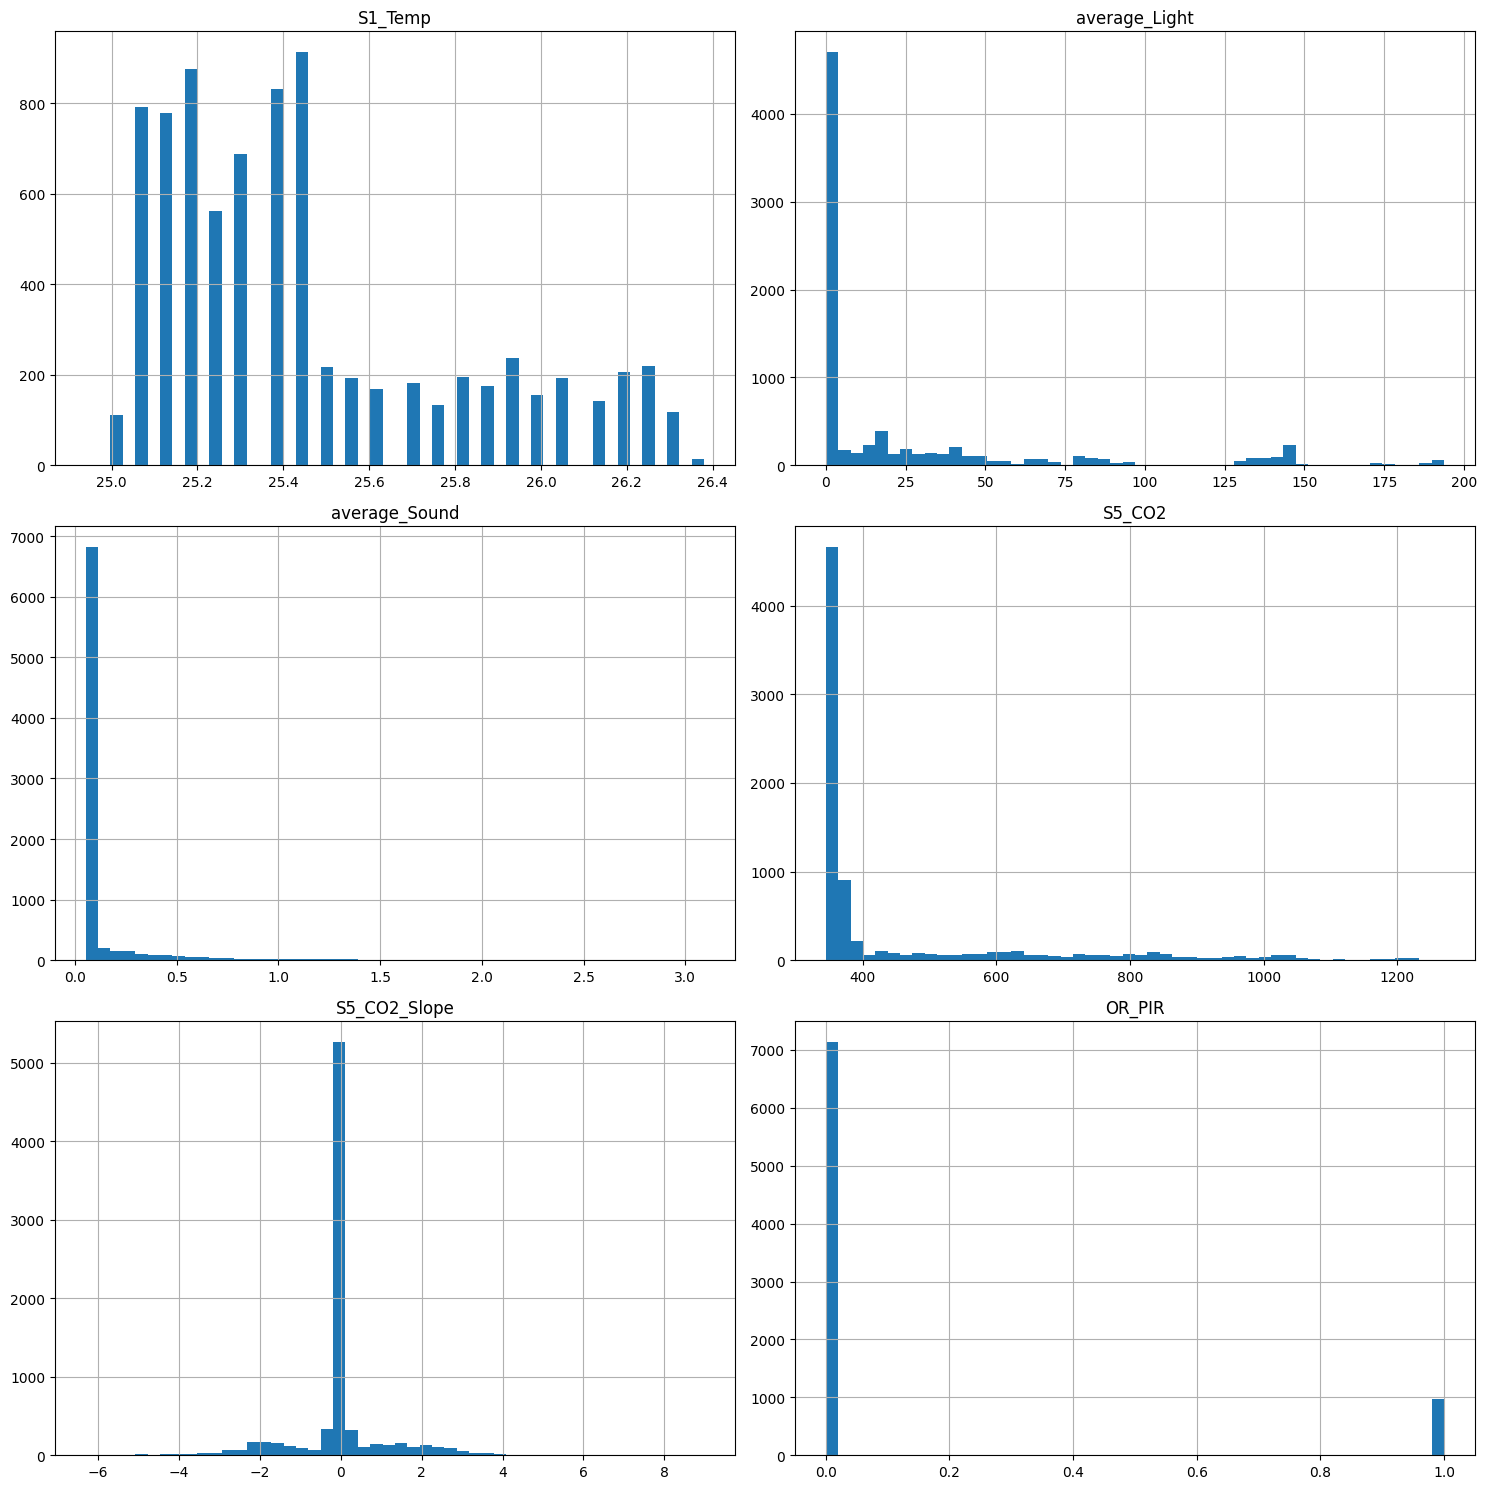

In [472]:
# plotting values in an attempt to determine the correct transformer
occupancy.hist(bins=50, figsize=(15, 15))
save_fig("occupancy_histogram_plots")

In [502]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, QuantileTransformer, RobustScaler, MaxAbsScaler, FunctionTransformer
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np

numerical_columns = ["average_Light", "average_Sound", "S5_CO2", "S5_CO2_Slope", "S1_Temp"]
binary_columns = ['OR_PIR']

#Custom Function Transformers
epsilon = np.finfo(float).eps
shift_value = abs(occupancy[numerical_columns].min().min()) + epsilon
log_transformer = FunctionTransformer(lambda x: np.log1p(x + shift_value))
sqrt_transformer = FunctionTransformer(lambda x: np.sqrt(x + shift_value))

# Create a new DataFrame for the transformed data
occupancy_prepared = occupancy[numerical_columns].copy()

# Create a pipeline that applies the Yeo-Johnson transformation, then StandardScaler, then MinMaxScaler, and finally the RBF kernel
pipeline = make_pipeline(sqrt_transformer)
# PowerTransformer(method='yeo-johnson')
# Apply the pipeline to each column
for col in numerical_columns:
    occupancy_prepared[col] = pipeline.fit_transform(occupancy[[col]])

# Add the 'OR_PIR' column to the prepared dataset
occupancy_prepared['OR_PIR'] = occupancy['OR_PIR']

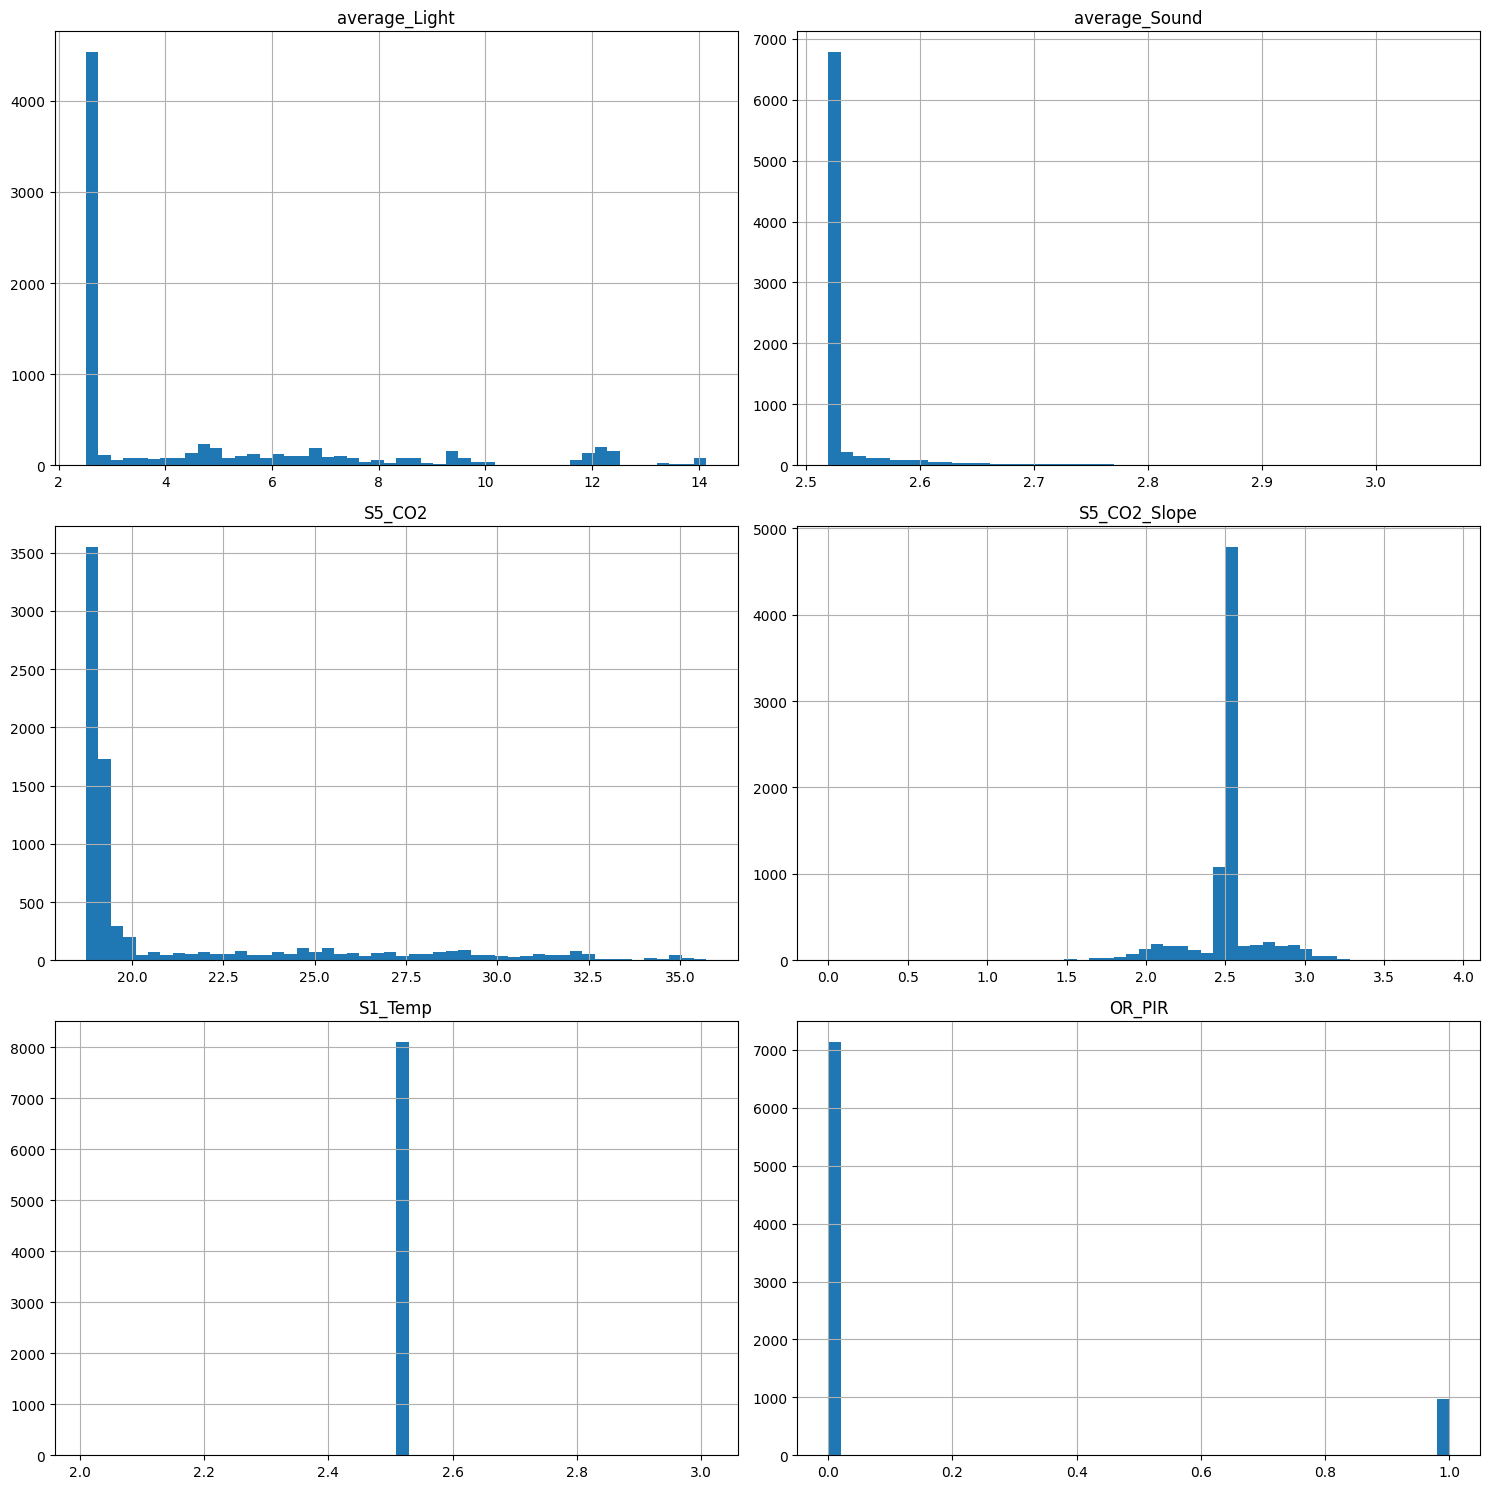

In [503]:
# plotting values in an attempt to determine the correct transformer
occupancy_prepared.hist(bins=50, figsize=(15, 15))
save_fig("occupancy_Preped_histogram_plots")

In [475]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(occupancy_prepared, occupancy_labels)

LinearRegression()

In [476]:
occupancy_predictions = model.predict(occupancy_prepared)
occupancy_predictions[:40].round(-2)


array([-0., -0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0.,  0., -0., -0.,
        0., -0., -0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,
        0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0.,
        0.])

In [477]:
occupancy_labels.iloc[:40].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 1, 3, 0], dtype=int64)

In [478]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(occupancy_labels, occupancy_predictions,
                              squared=False)
lin_rmse




0.3220554545438751

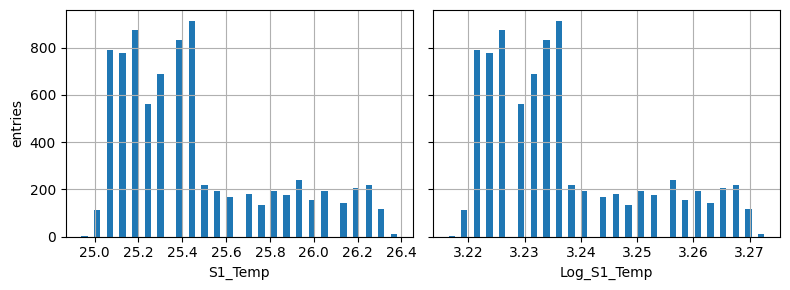

In [479]:
# Add a small constant to avoid logarithm of zero or negative values
occupancy["log_S1_Temp"] = np.log(occupancy["S1_Temp"])

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# Plot histogram of 'average_Light'
occupancy["S1_Temp"].hist(ax=axs[0], bins=50)
axs[0].set_xlabel("S1_Temp")
axs[0].set_ylabel("entries")

# Plot histogram of log-transformed 'average_Light'
occupancy["log_S1_Temp"].hist(ax=axs[1], bins=50)
axs[1].set_xlabel("Log_S1_Temp")

# Save and show the plot
plt.tight_layout()
plt.show()

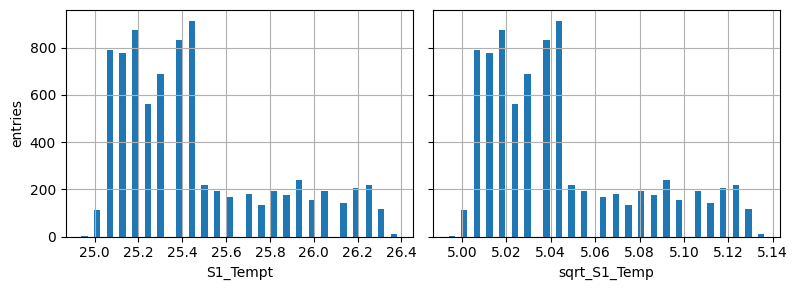

In [480]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
occupancy["S1_Temp"].hist(ax=axs[0], bins=50)
occupancy["S1_Temp"].apply(np.sqrt).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("S1_Tempt")
axs[1].set_xlabel("sqrt_S1_Temp")
axs[0].set_ylabel("entries")
save_fig("sqrt_tail_plot")
plt.show()

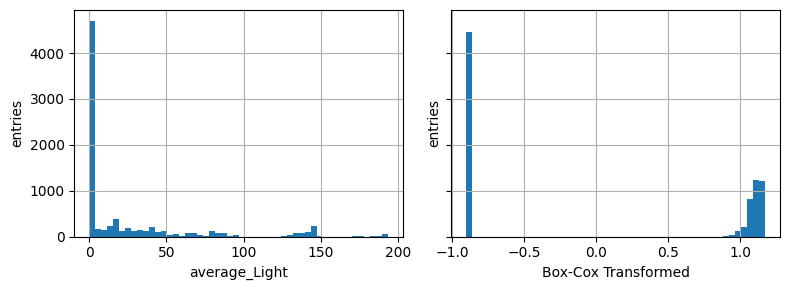

In [481]:
from sklearn.preprocessing import PowerTransformer

# Add a small constant epsilon to handle zeros or negative values
epsilon = np.finfo(float).eps
occupancy["average_Light"] = occupancy["average_Light"] + epsilon

# Assuming 'average_Light' is the column you want to transform
pt = PowerTransformer(method='box-cox')
occupancy["boxcox_transformed"] = pt.fit_transform(occupancy[["average_Light"]])

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

# Plot histogram of 'average_Light'
occupancy["average_Light"].hist(ax=axs[0], bins=50)
axs[0].set_xlabel("average_Light")
axs[0].set_ylabel("entries")

# Plot histogram of Box-Cox transformed 'average_Light'
occupancy["boxcox_transformed"].hist(ax=axs[1], bins=50)
axs[1].set_xlabel("Box-Cox Transformed")
axs[1].set_ylabel("entries")

# Save and show the plot
plt.tight_layout()
plt.show()


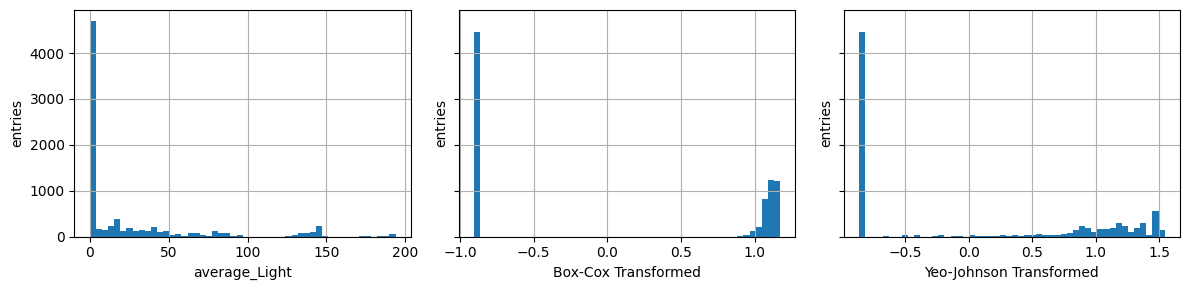

In [482]:
from sklearn.preprocessing import PowerTransformer

# Assuming 'average_Light' is the column you want to transform
pt = PowerTransformer(method='yeo-johnson')
occupancy["yeojohnson_transformed"] = pt.fit_transform(occupancy[["average_Light"]])

fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

# Plot histogram of 'average_Light'
occupancy["average_Light"].hist(ax=axs[0], bins=50)
axs[0].set_xlabel("average_Light")
axs[0].set_ylabel("entries")

# Plot histogram of Box-Cox transformed 'average_Light'
occupancy["boxcox_transformed"].hist(ax=axs[1], bins=50)
axs[1].set_xlabel("Box-Cox Transformed")
axs[1].set_ylabel("entries")

# Plot histogram of Yeo-Johnson transformed 'average_Light'
occupancy["yeojohnson_transformed"].hist(ax=axs[2], bins=50)
axs[2].set_xlabel("Yeo-Johnson Transformed")
axs[2].set_ylabel("entries")

# Save and show the plot
plt.tight_layout()
plt.show()


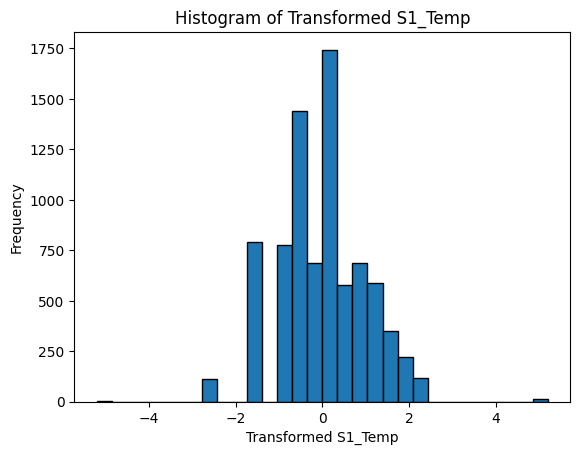

In [483]:
from sklearn.preprocessing import QuantileTransformer

# Create a QuantileTransformer object
qt = QuantileTransformer(output_distribution='normal')

# Fit the QuantileTransformer to your data and transform it
occupancy['S1_Temp'] = qt.fit_transform(occupancy[['S1_Temp']])

import matplotlib.pyplot as plt

# Create a histogram
plt.hist(occupancy['S1_Temp'], bins=30, edgecolor='black')

# Add title and labels
plt.title('Histogram of Transformed S1_Temp')
plt.xlabel('Transformed S1_Temp')
plt.ylabel('Frequency')

# Show the plot
plt.show()



In [484]:
from sklearn.metrics.pairwise import rbf_kernel

# Calculate RBF kernel
rbf_averagelight = rbf_kernel(occupancy[["S1_Temp"]], [[25.4]], gamma=0.2)

# Flatten the 2D array to 1D
rbf_averagelight = rbf_averagelight.flatten()

# Append the result to the DataFrame
occupancy["S1_Temp"] = rbf_averagelight

import matplotlib.pyplot as plt

# Create a histogram
plt.hist(occupancy['rbf_averagelight'], bins=30, edgecolor='black')

# Add title and labels
plt.title('Histogram of RBF S1_Temp')
plt.xlabel('RBF S1_Temp')
plt.ylabel('Frequency')

# Show the plot
plt.show()

KeyError: 'rbf_averagelight'

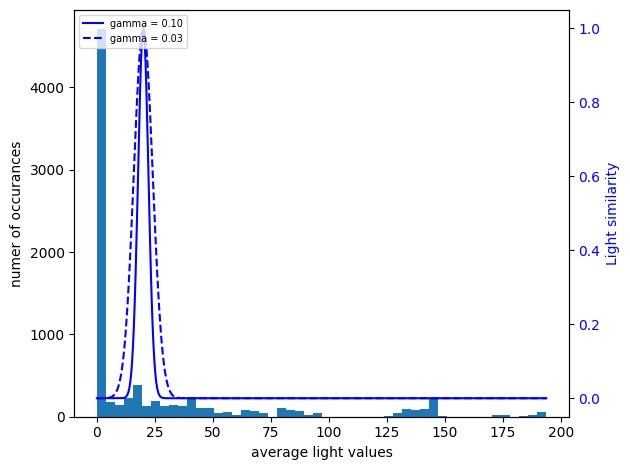

In [ ]:
# extra code – this cell generates a figure

light_values = np.linspace(occupancy["average_Light"].min() + epsilon,
                   occupancy["average_Light"].max(),
                   500).reshape(-1, 1)
gamma1 = 0.1
gamma2 = 0.03
rbf1 = rbf_kernel(light_values, [[20]], gamma=gamma1)
rbf2 = rbf_kernel(light_values, [[20]], gamma=gamma2)

fig, ax1 = plt.subplots()

ax1.set_xlabel("average light values")
ax1.set_ylabel("numer of occurances")
ax1.hist(occupancy["average_Light"], bins=50)

ax2 = ax1.twinx()  # create a twin axis that shares the same x-axis
color = "blue"
ax2.plot(light_values, rbf1, color=color, label="gamma = 0.10")
ax2.plot(light_values, rbf2, color=color, label="gamma = 0.03", linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("Light similarity", color=color)

plt.legend(loc="upper left")
save_fig("rbf_light_similarity_plot")
plt.show()

In [ ]:
# Assuming 'occupancy' contains your numerical features
numerical_features = occupancy.columns

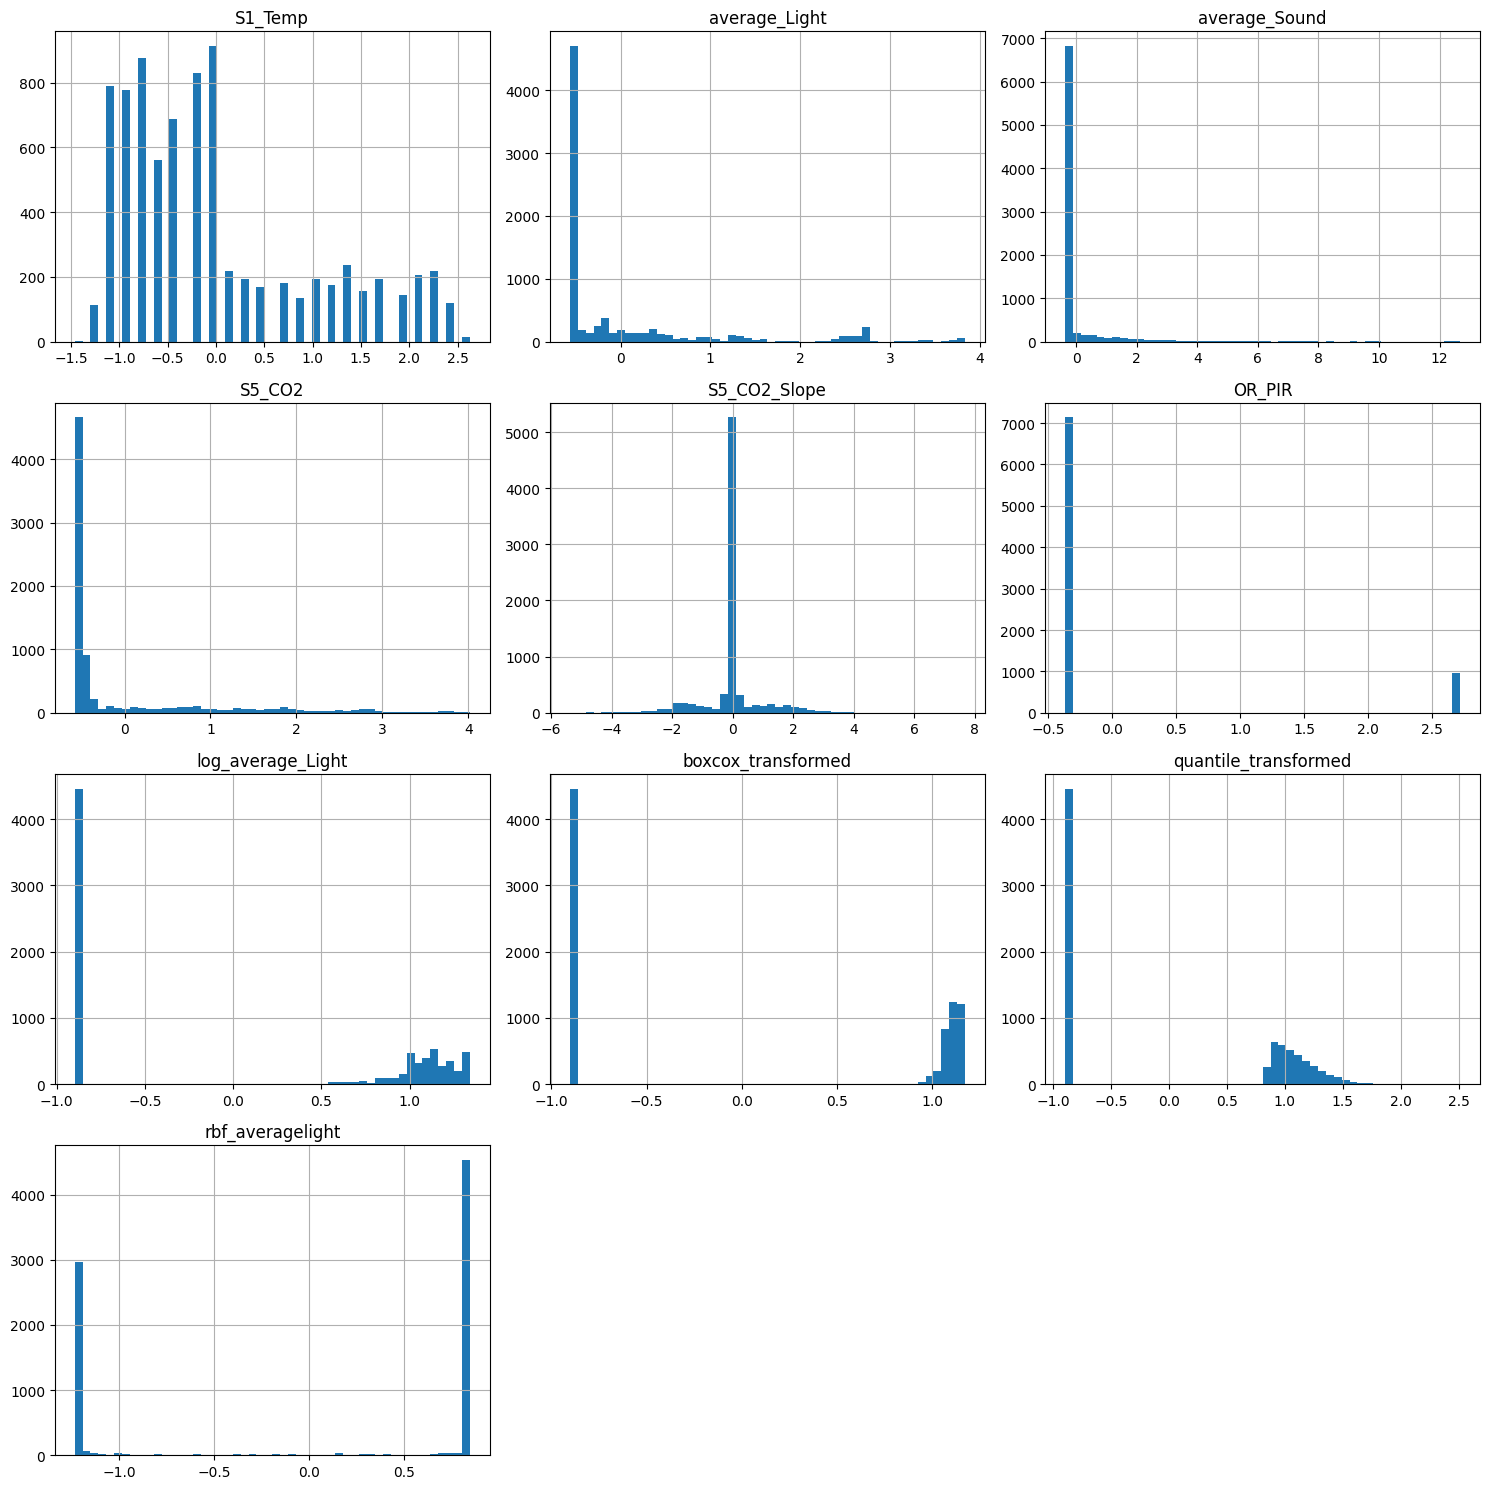

In [ ]:
from sklearn.preprocessing import StandardScaler


# Create a StandardScaler
scaler = StandardScaler()

# Fit and transform the scaler on the numerical features
occupancy_standard_scaled = scaler.fit_transform(occupancy)

# Convert the NumPy array back to a DataFrame
occupancy_standard_scaled_df = pd.DataFrame(occupancy_standard_scaled, columns=numerical_features)
occupancy_standard_scaled_df.hist(bins=50, figsize=(15, 15))
save_fig("occupancy_standard_scale_hisogram_plots", "images")

c:\Users\sebas\.virtualenvs\AI_Mini_Med7-Ndfdh7RZ\Lib\site-packages\sklearn\preprocessing\_data.py:2722: RuntimeWarning: invalid value encountered in subtract
  np.interp(X_col_finite, quantiles, self.references_)


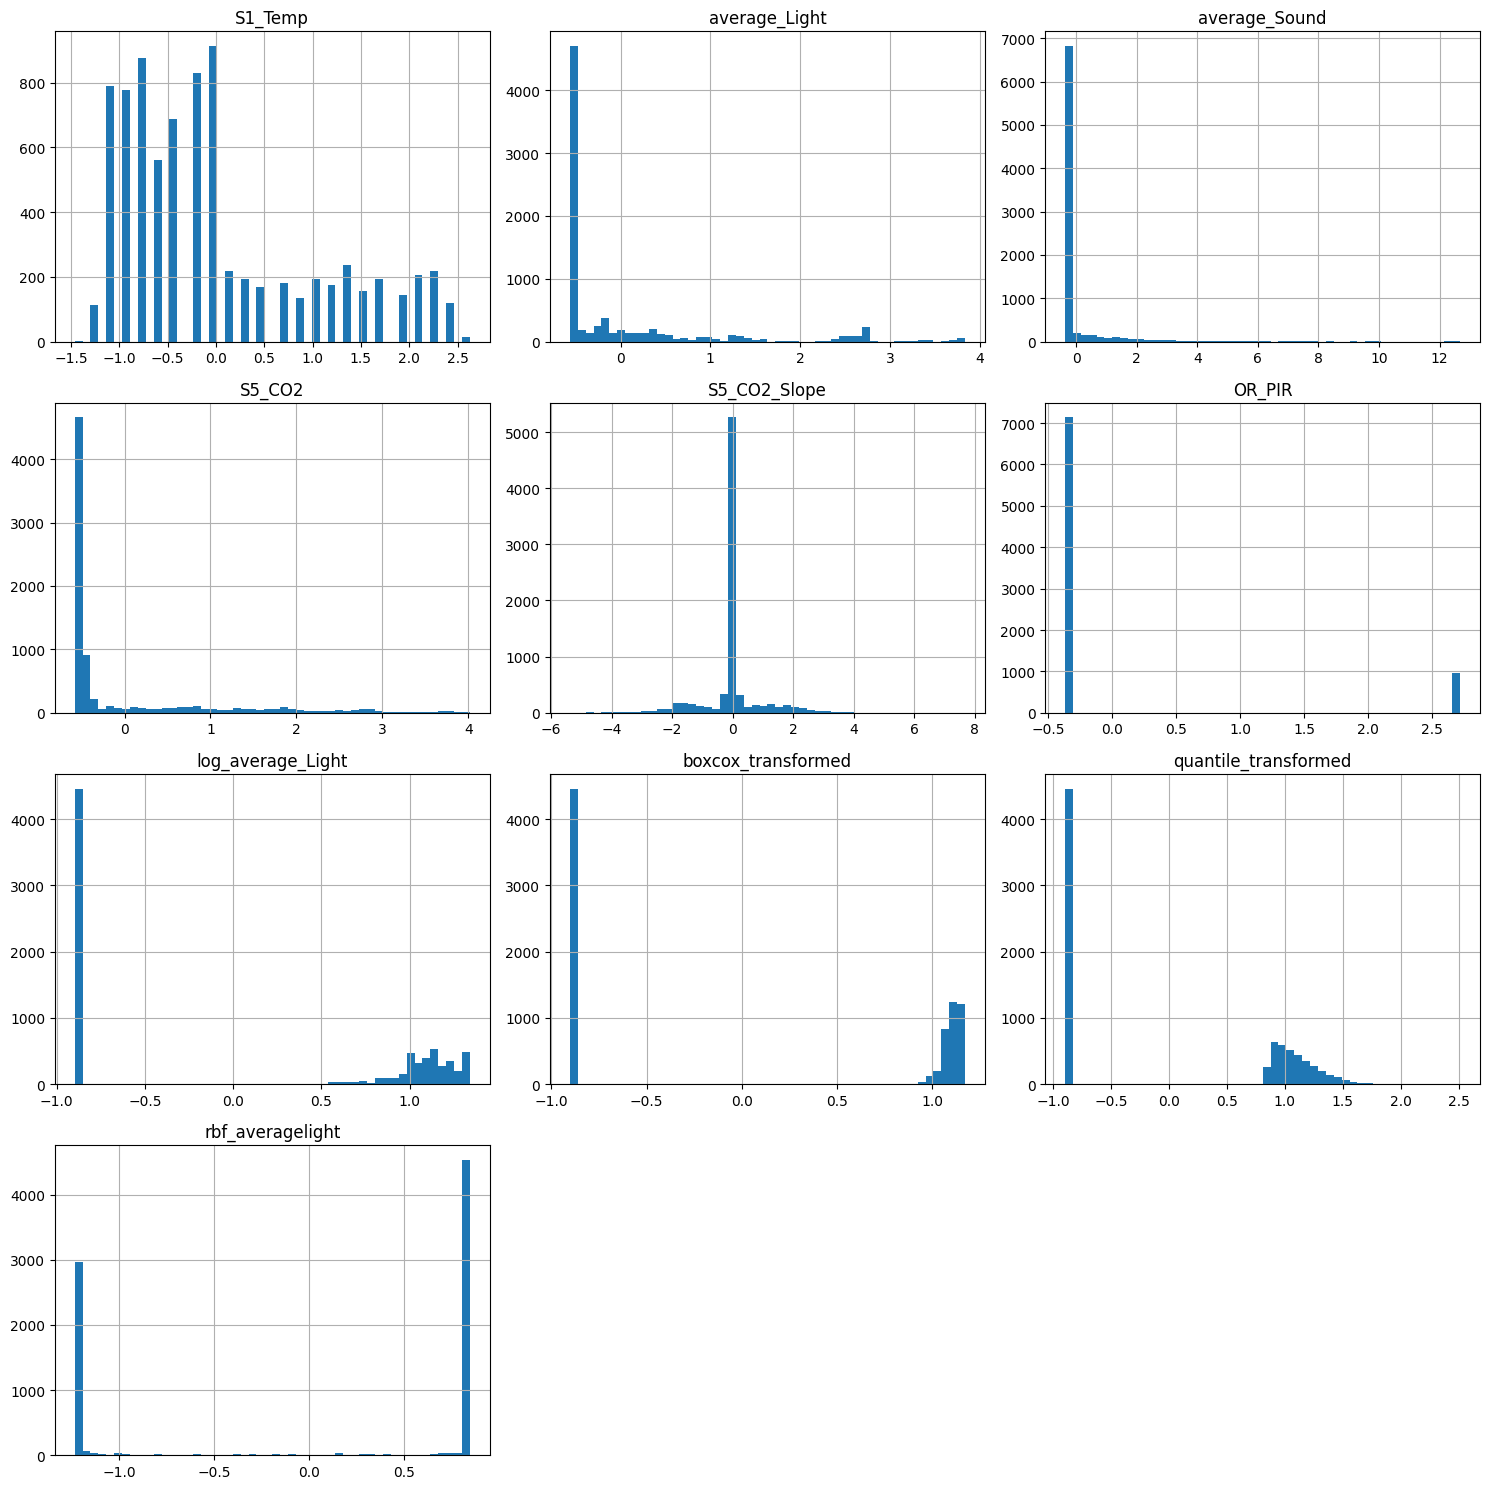

In [ ]:
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer()

occupancy_QuantileTransformer = scaler.fit_transform(occupancy)

# Convert the NumPy array back to a DataFrame
occupancy_QuantileTransformer_df = pd.DataFrame(occupancy_standard_scaled, columns=numerical_features)
occupancy_QuantileTransformer_df.hist(bins=50, figsize=(15, 15))
save_fig("occupancy_Quantile_hisogram_plots", "images")

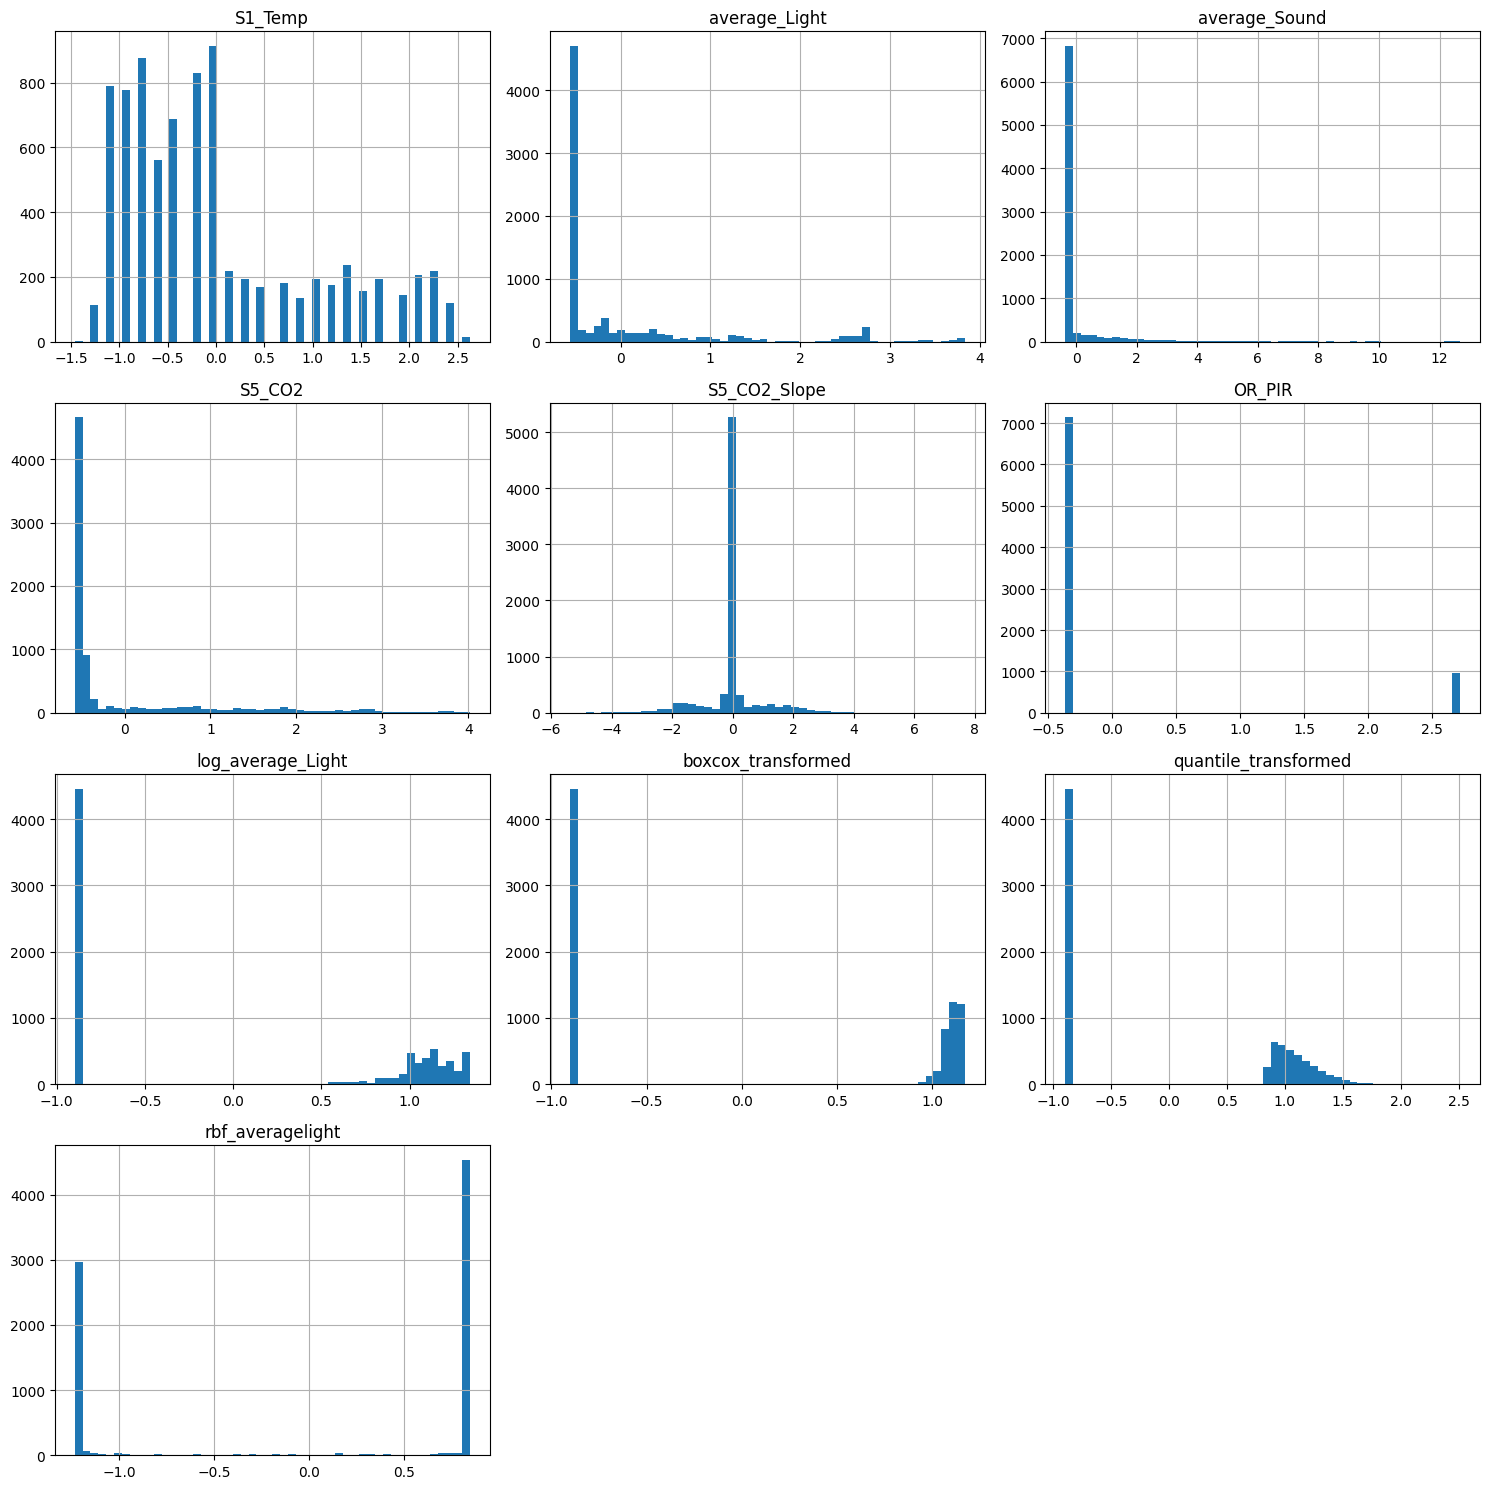

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

occupancy_MinMax = scaler.fit_transform(occupancy)

# Convert the NumPy array back to a DataFrame
occupancy_MinMax_df = pd.DataFrame(occupancy_standard_scaled, columns=numerical_features)
occupancy_MinMax_df.hist(bins=50, figsize=(15, 15))
save_fig("occupancy_MinMax_plots", "images")